In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.1

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
from jax import random
from scipy.linalg import circulant

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()

p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp


def getStepData(angles,thres=0):
    X=np.block([[np.cos(angles)],[np.sin(angles)]]).T
    Y=(np.sin(angles-np.pi/4)>=thres)[:,None]*2.0 - 1
    return X,Y

def get_tt(X,Y,train_ID):
    test_ID=np.invert(train_ID)
    x_train=X[train_ID,:]
    x_test=X[test_ID,:]
    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    return x_train,x_test,y_train,y_test

seed=100
np.random.seed(seed)

N_total=500
N_train=100

train_idx=np.random.choice(np.arange(N_total),N_train,replace=False)
train_ID=np.ones(N_total)==0
train_ID[train_idx]=True

#angles=np.arange(N_total)
#grayscale=False
#X,_,Y,_,_,_,same00,same01,same11,y_class=gp.getFashion(N_train=N_total,N_test=100,normalize=True,seed=seed,home=home)
#Y=Y[:,None]

angles=np.linspace(0,2*np.pi,N_total)
X,Y=getStepData(angles,thres=0.5)
#delta=0.1
#f=1
#Y = (1/np.arctan(1/delta))*np.arctan(np.sin(angles*f)/delta) [:,None] + 2.0

Y=Y-np.mean(Y)


x_train,x_test,y_train,y_test=get_tt(X,Y,train_ID)




env: XLA_PYTHON_CLIENT_MEM_FRACTION=.1


In [114]:
from scipy.optimize import fsolve
def getkfunc(s0,eta,P):
    def func_root(ka):
        return s0 + np.sum((ka*eta)/(ka+P*eta)) - ka
    return func_root

def getgam(eta,P,ka):
    return np.sum(P*np.square(eta)/np.square(ka+P*eta))
###

resolution=100000000#100000000
trapz_n=10000
chunk_size=100000

m=0
sigma=1.0
Ls=jnp.arange(2,20)
#pas=[0.4999,0.2,0.1]
pas=jnp.linspace(0.4999,0.01,20)
taus=gp.getTau(jnp.array(pas))
s0=0.0#1e-3#1e-3

P=N_train
N=N_total
alpha=P/N

errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
errTf=np.copy(errAf)
CS=np.copy(errAf)
ED=np.copy(errAf)
EDa=np.copy(errAf)
VN=np.copy(errAf)
COSA=np.copy(errAf)
CircM=circulant(np.arange(N_total)+1)
Phi_d,_,_=jnp.linalg.svd(CircM)
vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/jnp.sqrt(N_total)

offde=np.copy(errAf)
Kaps=np.copy(errAf)
Gams=np.copy(errAf)
etas=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N_total))
kshapes=np.copy(etas)
VT=np.copy(etas)
ERO=np.copy(etas)
DERO=np.copy(etas)
EROT=np.copy(etas)
Egt=np.copy(errAf)
for j, tau in enumerate(taus):
    #converter=gp.getConverter(tau=tau,resolution=100000,trapz_n=10000)#,chunk_size=10000)
    #converter=gp.getConverter(tau=tau,resolution=100000,trapz_n=10000,chunk_size=100000)
    converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
    #load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
    sigma=np.squeeze(gp.getosig(tau))
    load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        
    
    for g, L in enumerate(Ls):
    #try:
        #A=np.load(load_names_tr[g])
        K=np.load(load_names_te[g])
        A=K[train_ID,:][:,train_ID]
        C=K[train_ID,:]

        yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
        
        errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))

        print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, m:{}, L:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),m,L))
        
        #Phi_d,eta,_=jnp.linalg.svd(K)
        #M=np.sum(eta>0)
        #_,eta,_=jnp.linalg.svd(K)
        #vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/np.sqrt(M)
        
        smatrix=jnp.matmul(jnp.matmul(Phi_d.T,K),Phi_d)
        eta=jnp.diag(smatrix)
        offde[j,g]=np.sum( jnp.abs(smatrix - jnp.diag(jnp.diag(smatrix))) > 1e-5 )
        M=np.sum(eta>0)
        #####eta=eta/M
        
        eta_max=eta[0]
        eta=eta/eta_max
        s0norm=s0/eta_max
        
        #Phi_d=Phi_d*np.sqrt(M) why is this here?

        etas[j,g,:]=np.copy(eta)
        kshapes[j,g,:]=K[0,:]
        
        func_root=getkfunc(s0norm,np.array(eta),P)
        ka=fsolve(func_root,50)
        gam=getgam(eta,P,ka)

        Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
        Eg=np.squeeze(np.dot(Erhos,np.square(vteach)))
        errTf[j,g]=Eg
        
        eta=np.array(eta/eta[1])
        etan[0]=0#etan[1]
        erots=(1-alpha)*( 1-2*( (eta-1) - np.mean(eta-1)  )*alpha )
        EROT[j,g,:]=np.squeeze(erots)
        DERO[j,g,:]=-1*( (eta-1) - np.mean(eta-1) ) * 2*alpha*(1-alpha)
        Egt[j,g]=np.squeeze(np.dot(erots,np.square(vteach)))

        ###
        VT[j,g,:]=vteach
        ERO[j,g,:]=Erhos
        Kaps[j,g]=ka
        Gams[j,g]=gam
    #except:
    #    print('untrainable')
    del A
    del C
    del K
    del converter
    
etasn=etas/etas[:,:,1][:,:,None]


loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.24e+09, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:7.77e+03, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:2.05e+04, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:1.36e+03, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:3.97e+02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:3.35e+01, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:1.61e+01, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:6.66e+00, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:2.31e-01, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:4.45e+00, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:6.76e+01, sigma:1.41, pa:5.00e-01, m:0, L:12, 
e

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:2.50e+02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:2.10e+02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:1.70e+00, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:1.04e-01, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:1.48e-01, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:1.95e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:1.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:1.91e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:1.89e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:1.87e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:1.84e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:1.81e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:1.79e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:1.77e-

10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.46e+03, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:6.79e+01, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:1.52e-01, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:1.94e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:1.93e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:1.89e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:1.85e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:1.92e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:2.32e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:3.44e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:5.73e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:9.59e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:1.53e-01, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:2.27e-01, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:3.13e-01, sigma:3.18, pa:1.90e-01, m:0, L:16, 
err:4.06e-01, sigma:3.18, pa:1.90e-01, m:0, L:

16th layer kernel saved
17th layer kernel saved
done
err:8.42e+01, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:3.03e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:1.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:1.98e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:3.54e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:1.08e-01, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:2.58e-01, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.48e-01, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:6.14e-01, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:6.91e-01, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:7.07e-01, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:7.10e-01, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a file
0th layer kernel s

Text(0, 0.5, 'f')

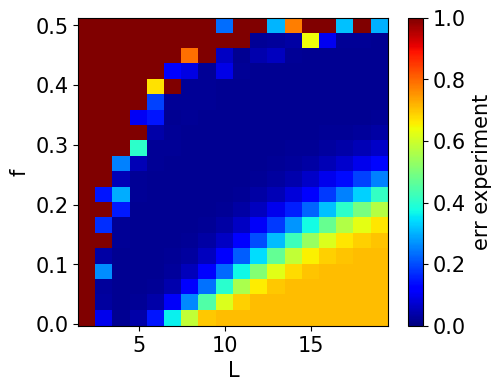

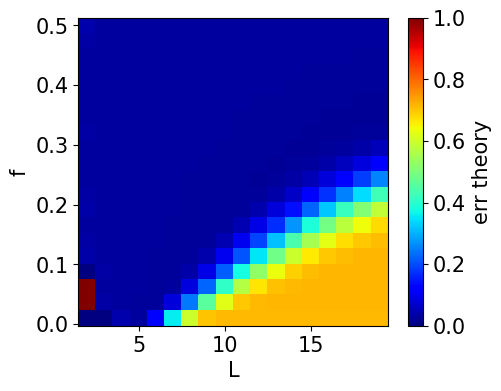

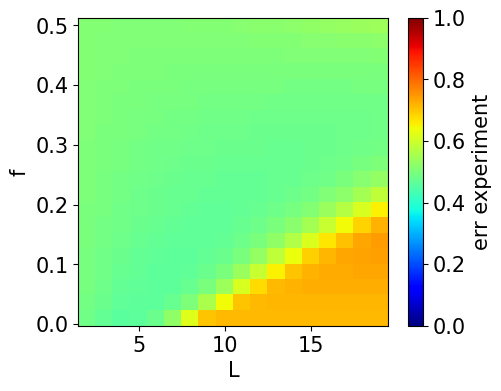

In [115]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.pcolor(Ls,pas,(errAf),cmap='jet',vmax=1,vmin=0)
cb=fig.colorbar(im, ax=ax)
cb.set_label('err experiment')
ax.set_xlabel('L')
ax.set_ylabel('f')

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.pcolor(Ls,pas,(errTf),cmap='jet',vmax=1,vmin=0)#,vmax=0.3,vmin=0.02)
cb=fig.colorbar(im, ax=ax)
cb.set_label('err theory')
ax.set_xlabel('L')
ax.set_ylabel('f')

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.pcolor(Ls,pas,(Egt),cmap='jet',vmax=1,vmin=0)
cb=fig.colorbar(im, ax=ax)
cb.set_label('err experiment')
ax.set_xlabel('L')
ax.set_ylabel('f')



(0.0, 2.0)

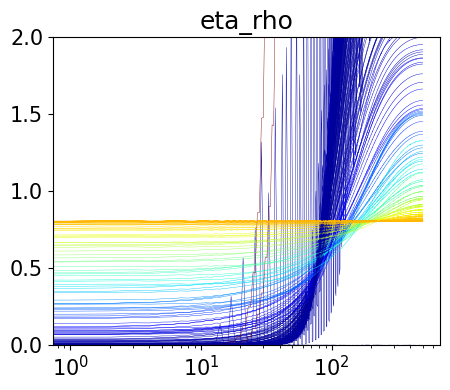

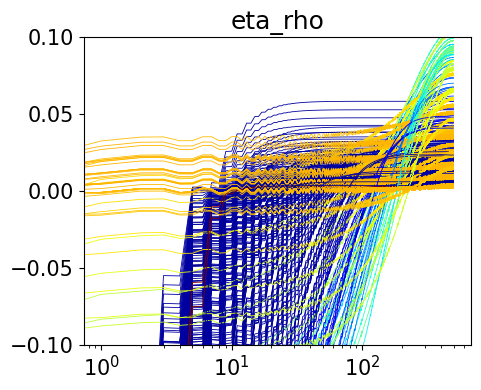

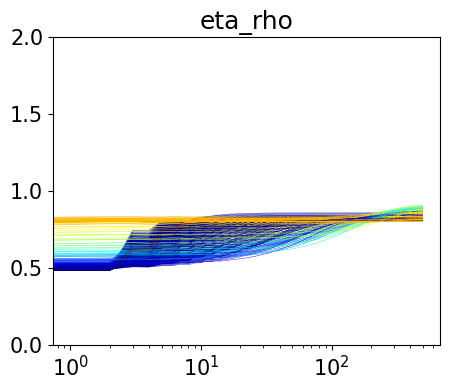

In [116]:
import matplotlib as mpl

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# convert your distances to color coordinates
color_list = cmap((errTf))


zc=10000
fig,ax=plt.subplots(1,1,figsize=(5,4))
for i in range(np.shape(ERO)[0]):
    for j in range(np.shape(ERO)[1]):
        ax.plot(ERO[i,j,:],c=color_list[i,j],lw=0.3,zorder=-zc);
        zc=zc-1
ax.set_title('eta_rho')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([0,2])

zc=10000
fig,ax=plt.subplots(1,1,figsize=(5,4))
for i in range(np.shape(ERO)[0]):
    for j in range(np.shape(ERO)[1]):
        ax.plot(DERO[i,j,:],c=color_list[i,j],lw=0.6,zorder=-zc);
        zc=zc-1
ax.set_title('eta_rho')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([-0.1,0.1])

zc=10000
fig,ax=plt.subplots(1,1,figsize=(5,4))
for i in range(np.shape(ERO)[0]):
    for j in range(np.shape(ERO)[1]):
        ax.plot((1-P/N)+DERO[i,j,:],c=color_list[i,j],lw=0.3,zorder=-zc);
        zc=zc-1
ax.set_title('eta_rho')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([0,2])


